In [1]:
import argparse
import sys
sys.path.append('../../gears_misc/')

from gears import PertData, GEARS

dataset = 'norman_go'
data_path = '/dfs/project/perturb-gnn/datasets/data/'
model = 'gears'
device = 7
preds = {}

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import glob
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

def plot_perturbation_err(gears_model, query, mean_pred, errorbars=None,
                          save_file = None, pred_query=None
                      ):

    adata = gears_model.adata
    gene2idx = gears_model.node_map
    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    cond2name = dict(adata.obs[['condition', 'condition_name']].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    if pred_query is not None:
        de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
        genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
    else:
        de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[query]]]
        genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[query]]]
    truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
    query_ = [q for q in query.split('+') if q != 'ctrl']
    pred = mean_pred
    
    ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[de_idx].values
    truth = truth - ctrl_means
                
    plt.figure(figsize=[16.5,4.5])
    plt.title(query)
    plt.boxplot(truth, showfliers=False,
                #patch_artist=True,
                #boxprops=dict(facecolor='None', color='darkgreen'),
                #capprops=dict(color='darkgreen'),
                #whiskerprops=dict(color='darkgreen'),
                medianprops = dict(linewidth=0))    

    for i in range(pred.shape[0]):
        _ = plt.scatter(i+1, pred[i], color='red', s=20)
        if errorbars is not None:
            plt.errorbar(i+1, pred[i], errorbars[i], color='red' )

    plt.axhline(0, linestyle="dashed", color = 'green')

    ax = plt.gca()
    ax.xaxis.set_ticklabels(genes, rotation = 90)

    plt.ylabel("Change in Gene Expression over Control",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=5)
    plt.tick_params(axis='y', which='major', pad=5)
    sns.despine()

    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


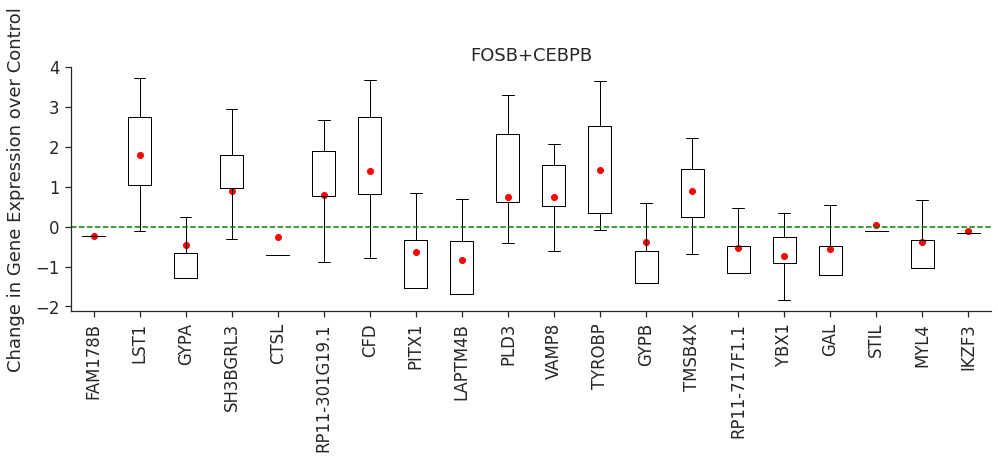

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


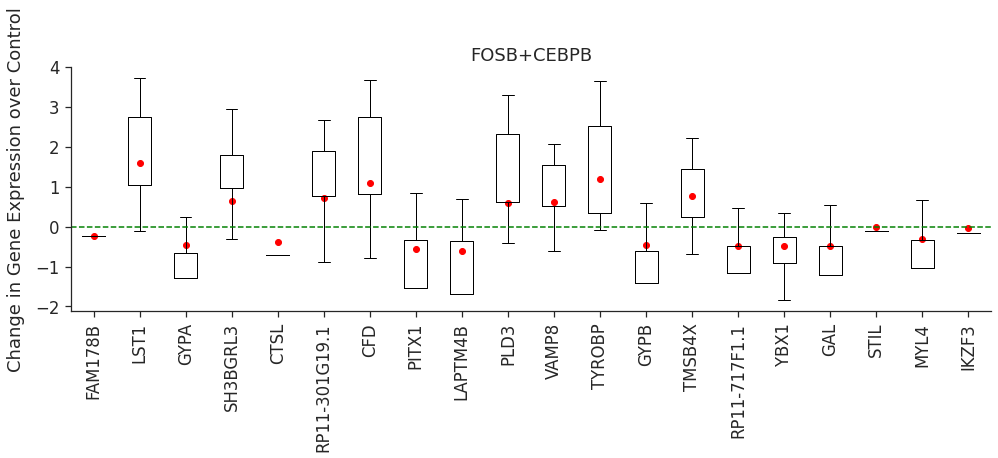

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


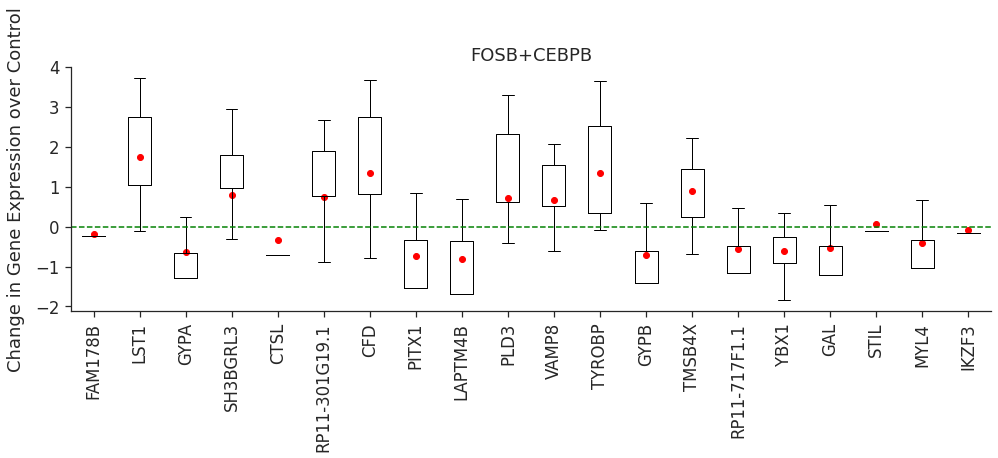

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


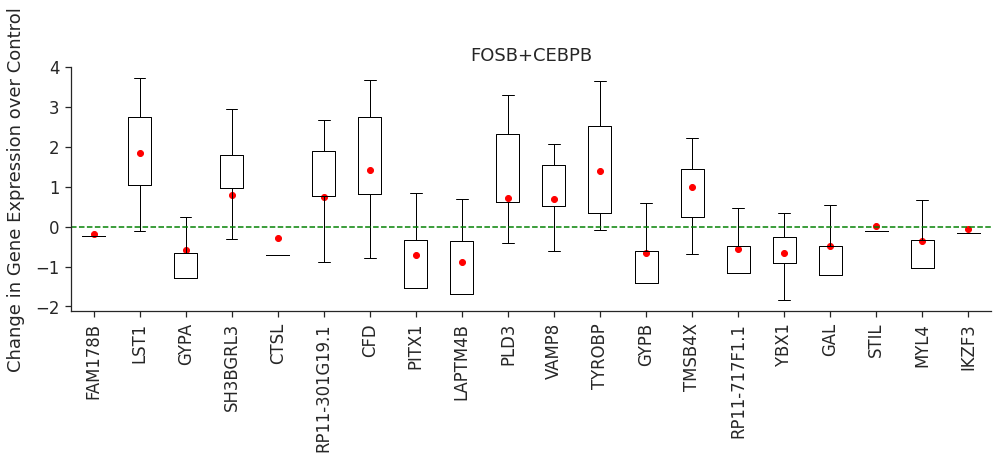

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


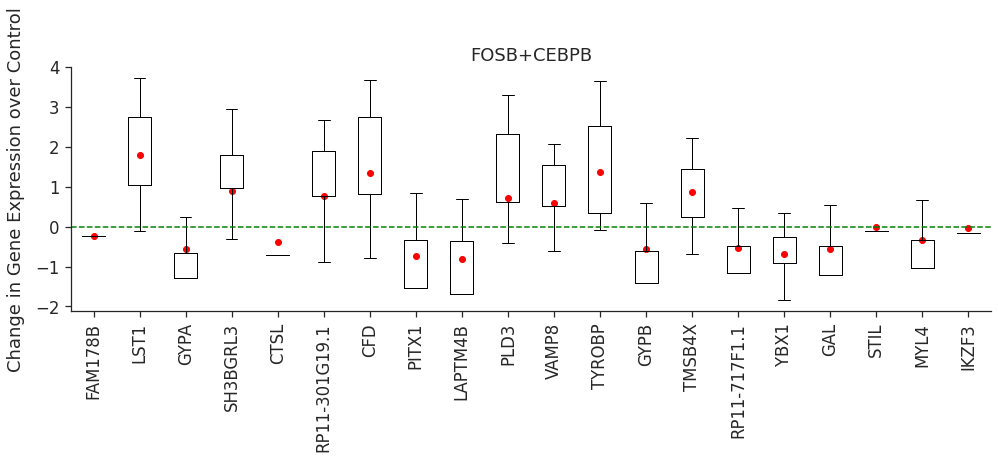

In [4]:
test_pert_genes = 'CEBPB'
for seed in range(10,15):
    pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
    pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.prepare_split(split = 'combo_seen1', seed = seed, test_pert_genes=test_pert_genes)
    pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)
    
    gears_model = GEARS(pert_data, device = 'cuda:' + str(device), 
                    weight_bias_track = False, 
                    proj_name =dataset, 
                    exp_name = str(model) + '_' + test_pert_genes + '_seed' + str(seed))
    gears_model.load_pretrained('./model_ckpt/' + dataset + '_' + model + '_' + test_pert_genes + '_run' + str(seed))
    
    de_idx_pert = 'FOSB+CEBPB'
    query = 'FOSB+CEBPB'

    adata = gears_model.adata
    gene2idx = gears_model.node_map
    cond2name = dict(adata.obs[['condition', 'condition_name']].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))
    
    preds[seed] = gears_model.plot_perturbation('FOSB+CEBPB')

In [6]:
import scipy

In [7]:
means = np.mean(list(preds.values()),0)
sds = np.std(list(preds.values()),0)
cis = [mean_confidence_interval(x) for x in np.vstack(preds.values()).T]

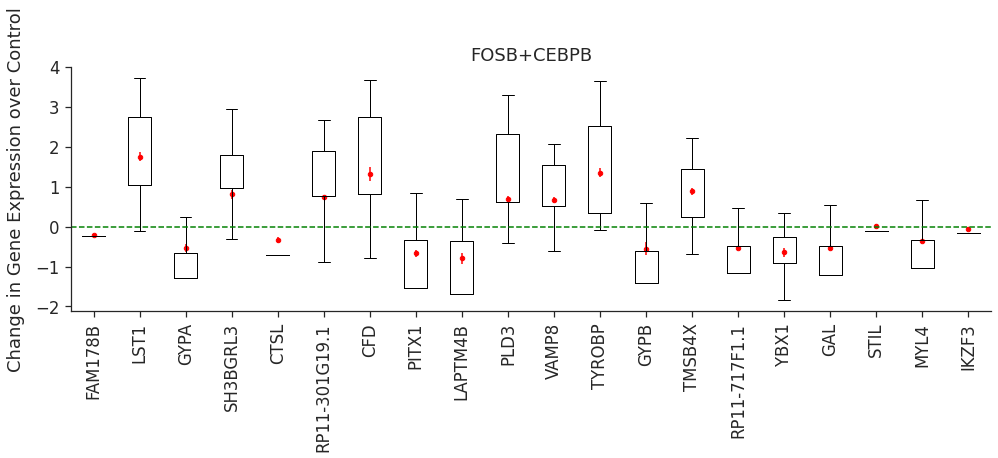

In [10]:
plot_perturbation_err(gears_model, query='FOSB+CEBPB', mean_pred =means, 
                      errorbars=cis, pred_query='FOSB+CEBPB', save_file='2g.pdf')

### Ext Data Figure 2

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


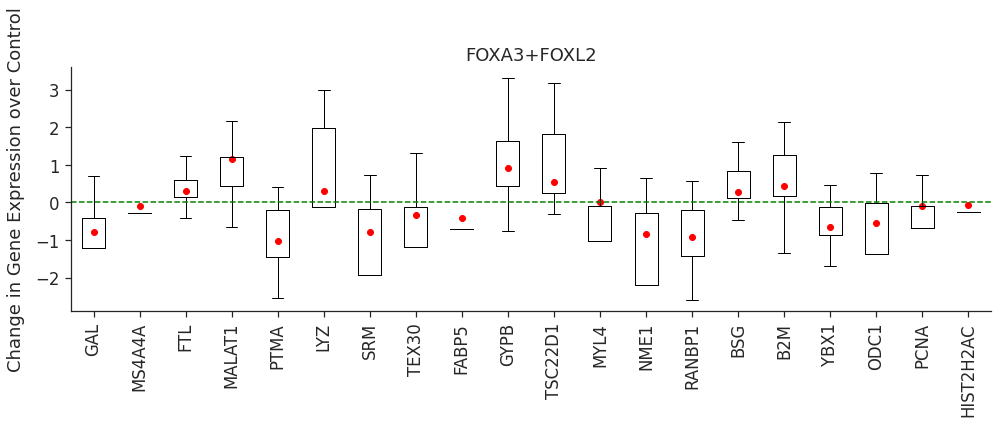

In [11]:
test_pert_genes = 'FOXA3'
seed = 1

pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'combo_seen1', seed = seed, test_pert_genes=test_pert_genes)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)

gears_model = GEARS(pert_data, device = 'cuda:' + str(device), 
                weight_bias_track = False, 
                proj_name =dataset, 
                exp_name = str(model) + '_' + test_pert_genes + '_seed' + str(seed))
gears_model.load_pretrained('./model_ckpt/' + dataset + '_' + model + '_' + test_pert_genes + '_run' + str(seed))

adata = gears_model.adata
gene2idx = gears_model.node_map
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

preds[seed] = gears_model.plot_perturbation('FOXA3+FOXL2', save_file='a.pdf')

In [ ]:
test_pert_genes = 'CEBPB'

seed = 13

pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'combo_seen1', seed = seed, test_pert_genes=test_pert_genes)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)

gears_model = GEARS(pert_data, device = 'cuda:' + str(device), 
                weight_bias_track = False, 
                proj_name =dataset, 
                exp_name = str(model) + '_' + test_pert_genes + '_seed' + str(seed))
gears_model.load_pretrained('./model_ckpt/' + dataset + '_' + model + '_' + test_pert_genes + '_run' + str(seed))

adata = gears_model.adata
gene2idx = gears_model.node_map
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

#plt.savefig('pert_boxplot')

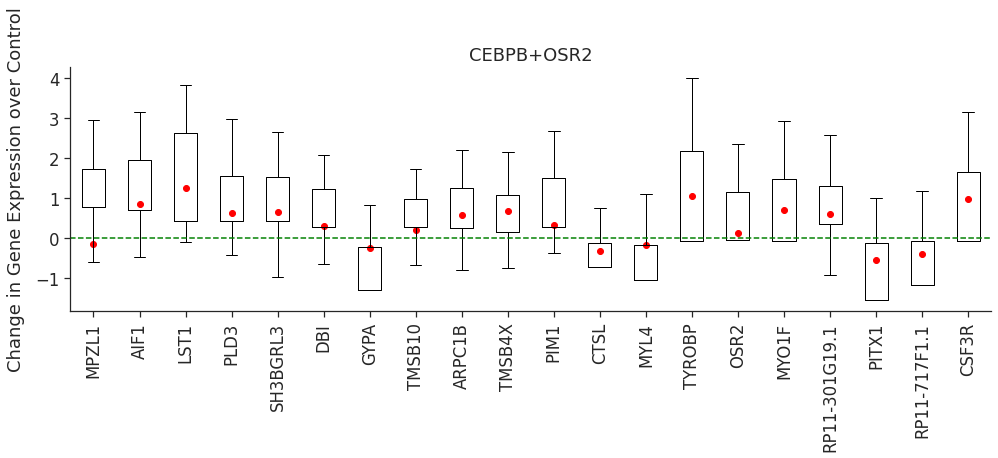

array([-0.13959649,  0.84673905,  1.2656317 ,  0.62505764,  0.6534466 ,
        0.3161298 , -0.24386525,  0.21556044,  0.58404803,  0.67560387,
        0.3262287 , -0.31106752, -0.17954731,  1.060933  ,  0.14204368,
        0.70801395,  0.6180345 , -0.53960323, -0.3978318 ,  0.988654  ],
      dtype=float32)

In [10]:
gears_model.plot_perturbation('CEBPB+OSR2', save_file='b.pdf')

In [9]:
dataset = 'norman_umi_go'
data_path = '/dfs/project/perturb-gnn/datasets/data/'

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


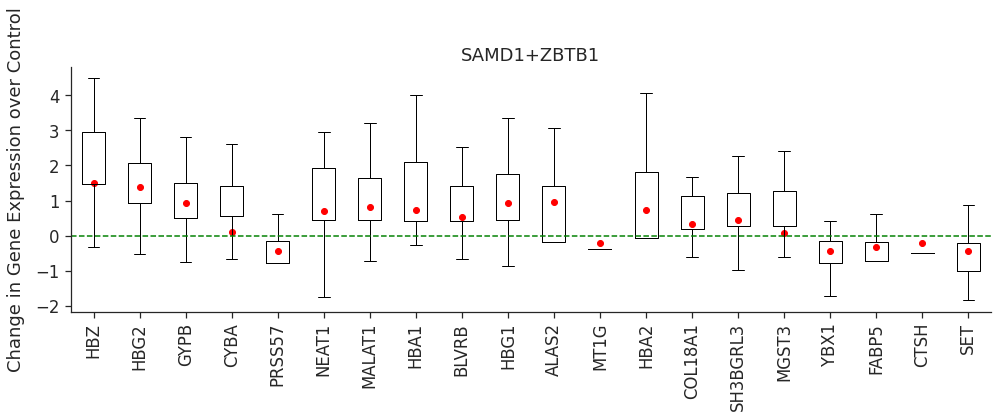

array([ 1.493118  ,  1.3907039 ,  0.9380275 ,  0.09609747, -0.42359415,
        0.70270085,  0.80758286,  0.7425518 ,  0.52538973,  0.94409364,
        0.9698355 , -0.2032449 ,  0.72563213,  0.32040668,  0.44471258,
        0.08103877, -0.44649553, -0.31149653, -0.19800645, -0.43816686],
      dtype=float32)

In [6]:
test_pert = 'SAMD1+ZBTB1'
seed = 1

pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'combo_seen2', seed = seed, test_perts = test_pert)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)

gears_model = GEARS(pert_data, device = 'cuda:8', 
            weight_bias_track = False, 
            proj_name = 'norman_go', 
            exp_name = 'gears')
gears_model.load_pretrained('./model_ckpt/GI/norman_umi_go_' + test_pert)

gears_model.plot_perturbation(test_pert, save_file='c.pdf')

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


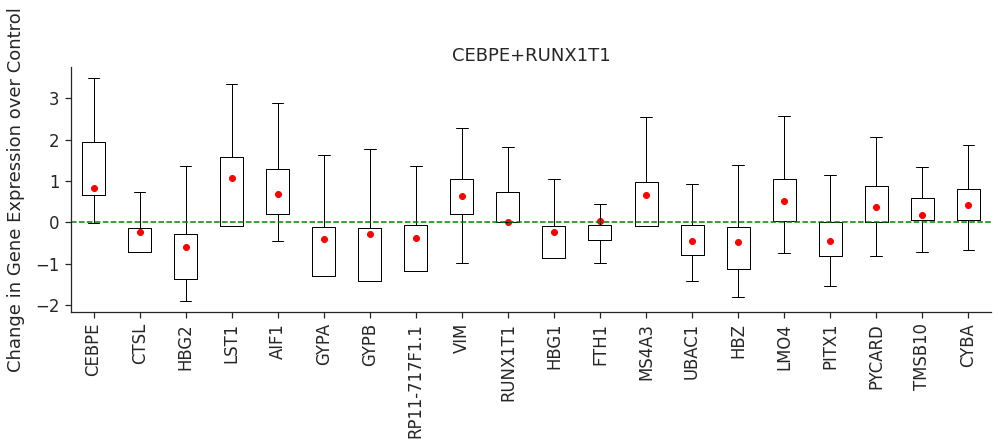

array([ 0.8356187 , -0.23715264, -0.58338237,  1.0753046 ,  0.6900321 ,
       -0.41092044, -0.28433657, -0.366782  ,  0.6410274 ,  0.02116683,
       -0.24376655,  0.04422617,  0.66850114, -0.44208956, -0.4634874 ,
        0.51969475, -0.43784082,  0.37879127,  0.16733742,  0.41284382],
      dtype=float32)

In [5]:
test_pert = 'CEBPE+RUNX1T1'

pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'combo_seen2', seed = seed, test_perts = test_pert)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)

gears_model = GEARS(pert_data, device = 'cuda:8', 
            weight_bias_track = False, 
            proj_name = 'norman_go', 
            exp_name = 'gears')
gears_model.load_pretrained('./model_ckpt/GI/norman_umi_go_' + test_pert)

gears_model.plot_perturbation(test_pert, save_file='d.pdf')

### Supplementary Information

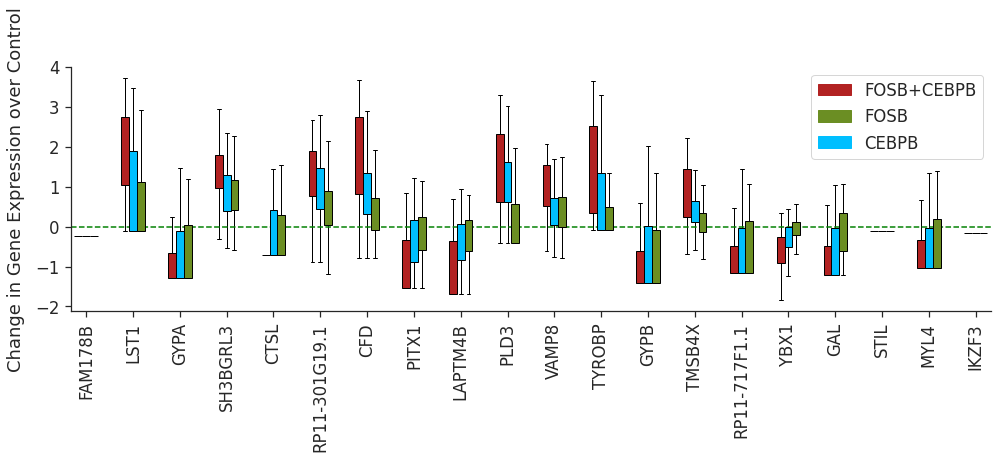

In [75]:
adata = gears_model.adata
gene2idx = gears_model.node_map
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
cond2name = dict(adata.obs[['condition', 'condition_name']].values)
gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

truths = {}

## FOSB + CEBPB

pred_query = 'FOSB+CEBPB'
query = 'FOSB+CEBPB'

de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
query_ = [q for q in query.split('+') if q != 'ctrl']

ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[de_idx].values
truth = truth - ctrl_means
truths[query] = truth

plt.figure(figsize=[16.5,4.5])
plt.title(query)
plt.boxplot(truth, showfliers=False, widths=0.5, 
            positions=3*np.arange(len(de_idx)),
            patch_artist=True,
            boxprops=dict(facecolor='firebrick', color='black'),
            medianprops = dict(linewidth=0))    

## CEBPB
query = 'CEBPB+ctrl'
de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
query_ = [q for q in query.split('+') if q != 'ctrl']

ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[de_idx].values
truth = truth - ctrl_means
truths[query] = truth

plt.boxplot(truth, showfliers=False, widths=0.5, 
            positions=3*np.arange(len(de_idx))+0.5,
            patch_artist=True,
            boxprops=dict(facecolor='deepskyblue', color='black'),
            medianprops = dict(linewidth=0))   



## FOSB 

query = 'FOSB+ctrl'
de_idx = [gene2idx[gene_raw2id[i]] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
genes = [gene_raw2id[i] for i in adata.uns['top_non_dropout_de_20'][cond2name[pred_query]]]
truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
query_ = [q for q in query.split('+') if q != 'ctrl']

ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean()[de_idx].values
truth = truth - ctrl_means
truths[query] = truth

plt.boxplot(truth, showfliers=False, widths=0.5, 
            positions=3*np.arange(len(de_idx))+1.0,
            patch_artist=True,
            boxprops=dict(facecolor='olivedrab', color='black'),
            medianprops = dict(linewidth=0))   





plt.axhline(0, linestyle="dashed", color = 'green')
plt.ylabel("Change in Gene Expression over Control",labelpad=10)

ax = plt.gca()
ax.xaxis.set_ticks(3*np.arange(len(de_idx))+0.5)
ax.xaxis.set_ticklabels(genes, rotation = 90)

plt.tick_params(axis='x', which='major', pad=5)
plt.tick_params(axis='y', which='major', pad=5)
sns.despine()

red_patch = mpatches.Patch(color='firebrick', label='FOSB+CEBPB')
green_patch = mpatches.Patch(color='olivedrab', label='FOSB')
blue_patch = mpatches.Patch(color='deepskyblue', label='CEBPB')

plt.title('')
plt.savefig('Difference over unperturbed')

plt.legend(handles=[red_patch, green_patch, blue_patch], facecolor='white')

#plt.show()